# Setup

## Libraries

In [1]:
!nvidia-smi

Mon May 13 23:33:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
pip install tensorflow-gpu==2.0.0-alpha

In [3]:
pip install tfp-nightly

In [4]:
pip install feather-format

In [5]:
pip install PyDrive

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

from tensorflow.keras import layers
from tensorflow.keras.metrics import Accuracy, CategoricalAccuracy, BinaryAccuracy

print("tensorflow version: " + tf.version.VERSION)
print("tensorflow keras version: " + tf.keras.__version__)

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

import pandas as pd
import timeit
import time
import sklearn

tensorflow version: 2.0.0-alpha0
tensorflow keras version: 2.2.4-tf


## Functions

In [0]:
time_log = []
def tic():
    time_log.append(time.perf_counter())

def toc(msg = ""):
    time_log.append(time.perf_counter())
    if (len(msg) != 0): msg += ": "
    time_diff = time_log.pop() - time_log.pop()
    unit = "seconds"
    if time_diff < .01:
      time_diff *= 1000
      unit = "milliseconds"
    print(msg + str("%.3f" % time_diff) + " " + unit)
    
def score_report(message, score):
    print(message + ": " + str('%.5f' % score))

# Data Import

In [0]:
df = pd.read_csv("http://users.stat.ufl.edu/~winner/data/nfl2008_fga.csv")

# Data Cleaning and Wrangling

In [0]:
df['timeremhalf'] = df.timerem %(60 * 30)
df['overtime'] = df.qtr == 5
df['twominutewarning'] = ((df.qtr == 4)|(df.qtr == 2))&(df.timeremhalf <= 120)
df['fourth_qtr'] = df.qtr == 4

In [0]:
df = df.drop(columns='season')
df.GameDate = df.GameDate.astype(int)
df['year'] = df.GameDate // 10000
df['month'] = (df.GameDate % 10000) // 100
df['day'] = df.GameDate % 100
df.GameDate = pd.to_datetime(df[['month','day','year']])
df['close_score'] = df.kickdiff.abs() <= 8
df['score_can_change'] = (df.kickdiff >= -3) & (df.kickdiff <= 0)

In [0]:
df.GOOD -= df.Blocked
df['result'] = df.Blocked * 2 + df.Missed
df.result = df.result.astype(int)

In [12]:
X = df[['distance','homekick','close_score','score_can_change','fourth_qtr','overtime','twominutewarning']]
X.close_score = X.close_score + 0.
X.score_can_change = X.score_can_change + 0.
X.fourth_qtr = X.fourth_qtr + 0.
X.overtime = X.overtime + 0.
X.twominutewarning = X.twominutewarning + 0.

X.describe()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,distance,homekick,close_score,score_can_change,fourth_qtr,overtime,twominutewarning
count,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000
mean,36.666025,0.494706,0.707411,0.335900,0.245428,0.012512,0.211742
std,9.847836,0.500213,0.455170,0.472532,0.430548,0.111209,0.408740
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,44.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,76.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
y = df[['GOOD','Missed','Blocked','result']]
y.describe()

,GOOD,Missed,Blocked,result
count,1039.000000,1039.000000,1039.000000,1039.000000
mean,0.845043,0.133782,0.021174,0.176131
std,0.362038,0.340582,0.144034,0.433172
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,2.000000


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [15]:
print(X_train.shape)
print(y_train.shape)

(779, 7)
(779, 4)


In [16]:
scaler = sklearn.preprocessing.MinMaxScaler()  
scaler.fit(X_train)  
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Neural Networks

## SciKit-Learn

In [0]:
from sklearn.neural_network import MLPClassifier

In [18]:
nn = MLPClassifier(hidden_layer_sizes=(12,10,8,6), max_iter= 10000, random_state = 10,n_iter_no_change= 100)
tic()
nn.fit(X_train_scaled, y_train.result)
toc('sklearn training time')
nn_predicted = nn.predict(X_test_scaled)

sklearn training time: 12.022 seconds


In [19]:
from sklearn.metrics import accuracy_score
score_report("test set accuracy",accuracy_score(nn_predicted, y_test.result))
score_report("training set accuracy",accuracy_score(nn.predict(X_train_scaled),y_train.result))
print(sklearn.metrics.classification_report(nn_predicted, y_test.result))

test set accuracy: 0.85000
training set accuracy: 0.86136
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       247
           1       0.18      0.46      0.26        13
           2       0.00      0.00      0.00         0

   micro avg       0.85      0.85      0.85       260
   macro avg       0.38      0.44      0.39       260
weighted avg       0.93      0.85      0.88       260



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


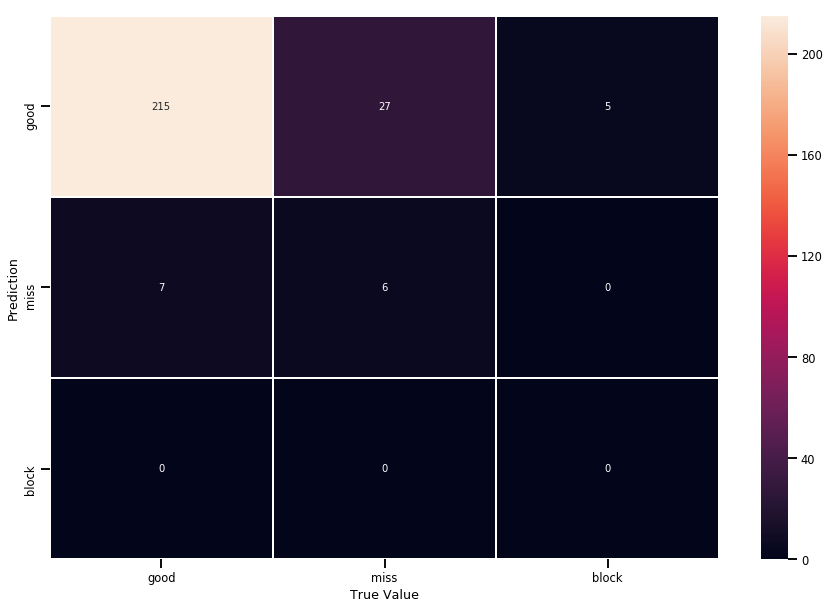

In [20]:
nn_cf = sklearn.metrics.confusion_matrix(nn_predicted,y_test.result)
nn_cf = pd.DataFrame(nn_cf, ['good','miss','block'], ['good','miss','block'])
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(nn_cf,linewidths=1,annot=True,fmt = 'd')
ax.set(ylabel = "Prediction", xlabel = "True Value")
plt.show()

## Tensorflow

### Utility Functions

In [0]:
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
      if epoch != 0:
        print(epoch)
      print('')
    print('.', end='')
    
class PrintDotTimed(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
      if epoch != 0:
        print('')
        toc('epoch ' + str(epoch))
      tic()
      print('')
    print('.', end='')

def plot_history_with_val(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('categorical_accuracy')
  plt.plot(hist['epoch'], hist['categorical_accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_categorical_accuracy'],
           label = 'Val Accuracy')
  plt.legend()
  plt.show()
  
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('categorical_accuracy')
  plt.plot(hist['epoch'], hist['categorical_accuracy'],
           label='Train Accuracy')
  plt.legend()
  plt.show()

### Setup

In [0]:
model = tf.keras.Sequential()
model.add(layers.Dense(50, activation='relu',input_shape = [X_train_scaled.shape[1]]))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(8, activation = 'sigmoid'))
model.add(layers.Dense(6, activation = 'sigmoid'))
model.add(layers.Dense(3, activation='softmax'))

optimizer = tf.keras.optimizers.Adam()

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy', 'categorical_accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                400       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 2

### Training

In [24]:
EPOCHS = 2000
tic()
history = model.fit(
  X_train_scaled, y_train.drop(columns='result'),
  epochs=EPOCHS, verbose=0,
  callbacks=[PrintDot()])
toc("tensorflow training time")


....................................................................................................100

....................................................................................................200

....................................................................................................300

....................................................................................................400

....................................................................................................500

....................................................................................................600

....................................................................................................700

....................................................................................................800

....................................................................................................900

......................................................

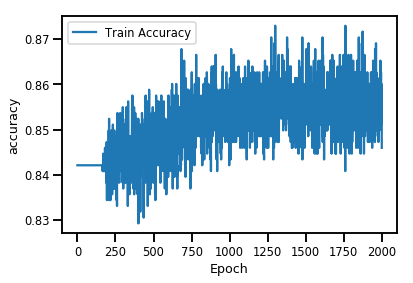

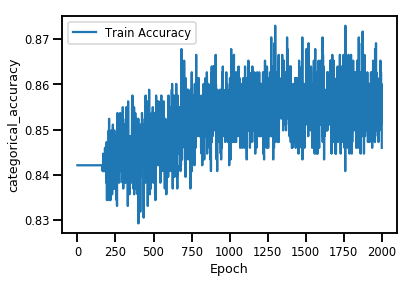

In [25]:
plot_history(history)

### Evaluation

In [26]:
model.evaluate(X_test_scaled, y_test.drop(columns = 'result'))

260/260 [==============================] - 0s 328us/sample - loss: 0.4508 - accuracy: 0.8423 - categorical_accuracy: 0.8423


[0.4508051468775823, 0.8423077, 0.8423077]

In [27]:
score_report("test accuracy",accuracy_score(model.predict_classes(X_test_scaled), y_test.result))
score_report("training accuracy",accuracy_score(model.predict_classes(X_train_scaled),y_train.result))
print(sklearn.metrics.classification_report(model.predict_classes(X_test_scaled), y_test.result))

test accuracy: 0.84231
training accuracy: 0.86136
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       243
           1       0.21      0.41      0.28        17
           2       0.00      0.00      0.00         0

   micro avg       0.84      0.84      0.84       260
   macro avg       0.39      0.43      0.40       260
weighted avg       0.91      0.84      0.87       260



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


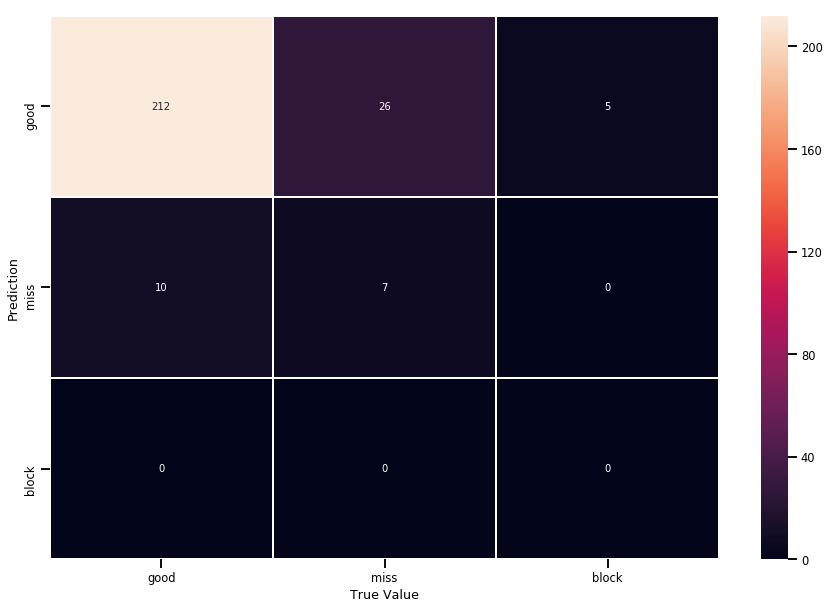

In [28]:
nn_cf = sklearn.metrics.confusion_matrix(model.predict_classes(X_test_scaled),y_test.result)
nn_cf = pd.DataFrame(nn_cf, ['good','miss','block'], ['good','miss','block'])
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(nn_cf,linewidths=1,annot=True,fmt = 'd')
ax.set(ylabel = "Prediction", xlabel = "True Value")
plt.show()

## sklearn overfitting

In [29]:
nn = MLPClassifier(hidden_layer_sizes=(100,80,60,50,40), max_iter= 10000, random_state = 10,n_iter_no_change= 250)
tic()
nn.fit(X_train_scaled, y_train.result)
toc('sklearn training time')
nn_predicted = nn.predict(X_test_scaled)

sklearn training time: 18.095 seconds


In [30]:
from sklearn.metrics import accuracy_score
score_report("test set accuracy",accuracy_score(nn_predicted, y_test.result))
score_report("training set accuracy",accuracy_score(nn.predict(X_train_scaled),y_train.result))

test set accuracy: 0.81923
training set accuracy: 0.89345


In [31]:
print(sklearn.metrics.classification_report(nn.predict(X_train_scaled), y_train.result))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       700
           1       0.50      0.73      0.59        73
           2       0.35      1.00      0.52         6

   micro avg       0.89      0.89      0.89       779
   macro avg       0.61      0.88      0.68       779
weighted avg       0.92      0.89      0.90       779



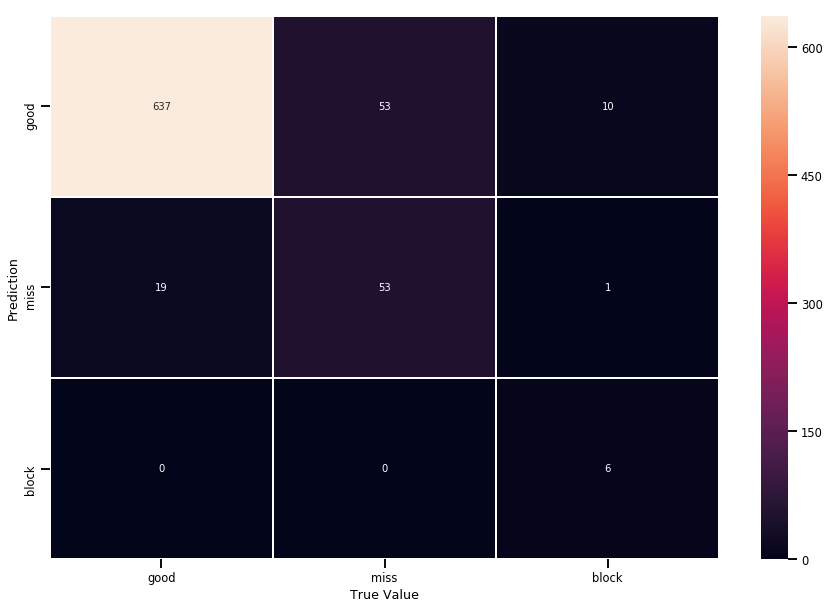

In [32]:
nn_cf = sklearn.metrics.confusion_matrix(nn.predict(X_train_scaled), y_train.result)
nn_cf = pd.DataFrame(nn_cf, ['good','miss','block'], ['good','miss','block'])
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(nn_cf,linewidths=1,annot=True,fmt = 'd')
ax.set(ylabel = "Prediction", xlabel = "True Value")
plt.show()

In [33]:
print(sklearn.metrics.classification_report(nn_predicted, y_test.result))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       241
           1       0.15      0.28      0.20        18
           2       0.00      0.00      0.00         1

   micro avg       0.82      0.82      0.82       260
   macro avg       0.36      0.38      0.36       260
weighted avg       0.88      0.82      0.85       260



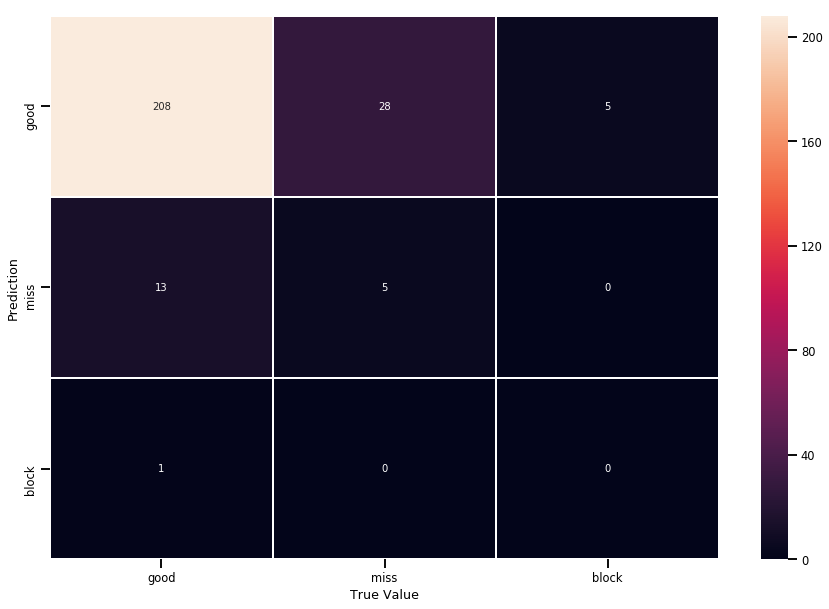

In [34]:
nn_cf = sklearn.metrics.confusion_matrix(nn_predicted,y_test.result)
nn_cf = pd.DataFrame(nn_cf, ['good','miss','block'], ['good','miss','block'])
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(nn_cf,linewidths=1,annot=True,fmt = 'd')
ax.set(ylabel = "Prediction", xlabel = "True Value")
plt.show()

# Larger Dataset

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
tic()
bigdf = pd.read_feather('drive/My Drive/data/NFL_pbp_2009_2018.feather')
toc('read feather from Google Drive')

read feather from Google Drive: 1.528 seconds


In [37]:
bigdf.shape

(452661, 203)

## Data Wrangling

In [0]:
kicks_df = bigdf.loc[pd.notna(bigdf.field_goal_result),].reset_index()

kicks_df.loc[kicks_df.kick_distance.isna(),'kick_distance'] = (kicks_df.loc[kicks_df.kick_distance.isna(),'yardline_100'] + 18)

kicks_df = kicks_df[['posteam_type','yardline_100','half_seconds_remaining','game_seconds_remaining','game_half','quarter','field_goal_result','kick_distance','score_differential','penalty','game_date']]

kicks_df.posteam_type = (kicks_df.posteam_type == 'home')

kicks_df = kicks_df.rename(columns={'posteam_type':'kicking_at_home'})

kicks_df['overtime'] = kicks_df.quarter == 5
kicks_df['two_minute_warning'] = kicks_df.half_seconds_remaining <= 120
kicks_df['fourth_quarter'] = kicks_df.quarter == 4

kicks_df['close_score'] = kicks_df.score_differential.abs() <= 8
kicks_df['lead_can_change'] = (kicks_df.score_differential >= -3) & (kicks_df.score_differential <= 0)

result_dict = {'made':0,'missed':1,'blocked':2}
half_map = {'Half1':1,'Half2':2,'Overtime':3}
kicks_df.game_half = kicks_df.game_half.map(half_map)
kicks_df.field_goal_result = kicks_df.field_goal_result.map(result_dict)

kicks_df = kicks_df.assign(weekday = kicks_df.game_date.map(pd.datetime.weekday))

days_dict = {6:'sunday',0:'monday',3:'thursday',5:'saturday',2:'other_day',1:'other_day',4:'other_day'}

kicks_df = kicks_df.join(
    kicks_df.assign(
        weekday = kicks_df.weekday.map(days_dict), temp = True
    ).pivot(columns = 'weekday', values = 'temp').fillna(False)
)
kicks_df = kicks_df.assign(good = kicks_df.field_goal_result == 0,miss = kicks_df.field_goal_result == 1,block = kicks_df.field_goal_result == 2)

In [39]:
kicks_df.describe()

,yardline_100,half_seconds_remaining,game_seconds_remaining,game_half,quarter,field_goal_result,kick_distance,score_differential,weekday
count,9872.000000,9872.000000,9872.000000,9872.000000,9872.000000,9872.000000,9872.000000,9872.000000,9872.000000
mean,19.525932,693.085190,1659.090053,1.479335,2.569287,0.182536,37.551053,0.559664,5.419976
std,10.255491,524.608069,983.173711,0.530671,1.108472,0.437233,10.251118,9.272946,1.596610
min,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,18.000000,-41.000000,0.000000
25%,11.000000,179.000000,817.000000,1.000000,2.000000,0.000000,29.000000,-4.000000,6.000000
50%,20.000000,665.000000,1804.000000,1.000000,2.000000,0.000000,38.000000,0.000000,6.000000
75%,28.000000,1158.250000,2438.000000,2.000000,4.000000,0.000000,46.000000,6.000000,6.000000
max,61.000000,1772.000000,3547.000000,3.000000,5.000000,2.000000,71.000000,46.000000,6.000000


In [40]:
X = kicks_df.drop(columns=['game_date','field_goal_result','good','miss','block','weekday'])
y = kicks_df[['good','miss','block','field_goal_result']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)
#X = X.kick_distance
scaler = sklearn.preprocessing.MinMaxScaler()  
scaler.fit(X_train)  
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [41]:
print(X_train.shape)
print(y_train.shape)

(7404, 19)
(7404, 4)


## Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(solver = 'lbfgs', max_iter=1000, random_state = 10)
logistic.fit(X_train,y_train.good.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [43]:
score_report('test score', logistic.score(X_test,y_test.good.values.ravel()))

score_report( 'training score', logistic.score(X_train,y_train.good.values.ravel()))

test score: 0.84522
training score: 0.84049


In [44]:
print(sklearn.metrics.classification_report(logistic.predict(X_test),y_test.good.values.ravel()))

              precision    recall  f1-score   support

       False       0.07      0.63      0.12        41
        True       0.99      0.85      0.92      2427

   micro avg       0.85      0.85      0.85      2468
   macro avg       0.53      0.74      0.52      2468
weighted avg       0.98      0.85      0.90      2468



In [45]:
pd.DataFrame(
    {"attribute" : X.columns.values,
     "coefficient" : logistic.coef_[0]}
)

,attribute,coefficient
0,kicking_at_home,0.014811
1,yardline_100,-0.280028
2,half_seconds_remaining,0.000051
3,game_seconds_remaining,0.000168
4,game_half,0.051796
5,quarter,0.109203
6,kick_distance,0.178765
7,score_differential,-0.000152
8,penalty,-0.000211
9,overtime,0.001080


## Neural Nets

### SciKit-Learn

In [46]:
nn = MLPClassifier(hidden_layer_sizes=(15,12,10,8,6), max_iter= 10000, n_iter_no_change=100, random_state = 10)
tic()
nn.fit(X_train_scaled, y_train.field_goal_result)
toc('sklearn nnet training')
nn_predicted = nn.predict(X_test_scaled)

score_report("test accuracy",accuracy_score(nn_predicted, y_test.field_goal_result))
score_report("training accuracy",accuracy_score(nn.predict(X_train_scaled),y_train.field_goal_result))
print(sklearn.metrics.classification_report(nn_predicted, y_test.field_goal_result))

sklearn nnet training: 42.976 seconds
test accuracy: 0.83630
training accuracy: 0.84616
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      2377
           1       0.11      0.42      0.17        91
           2       0.00      0.00      0.00         0

   micro avg       0.84      0.84      0.84      2468
   macro avg       0.36      0.42      0.36      2468
weighted avg       0.94      0.84      0.88      2468



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


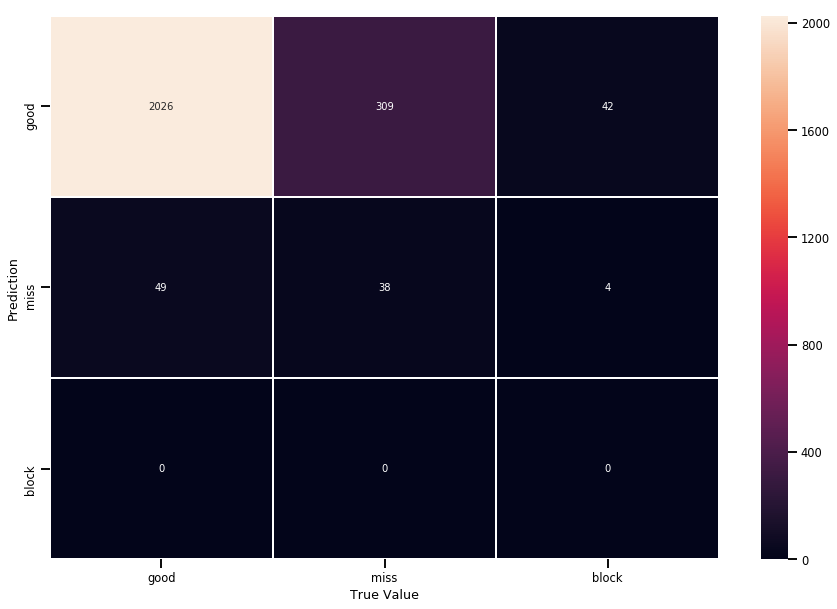

In [47]:
nn_cf = sklearn.metrics.confusion_matrix(nn_predicted,y_test.field_goal_result)
nn_cf = pd.DataFrame(nn_cf, ['good','miss','block'], ['good','miss','block'])
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(nn_cf,linewidths=1,annot=True,fmt = 'd')
ax.set(ylabel = "Prediction", xlabel = "True Value")
plt.show()

### TensorFlow

In [0]:
model = tf.keras.Sequential()
model.add(layers.Dense(30, activation='relu',input_shape = [X_train_scaled.shape[1]]))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(20, activation='relu',input_shape = [X_train_scaled.shape[1]]))
model.add(layers.Dropout(rate = 0.4))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(8, activation = 'sigmoid'))
model.add(layers.Dense(6, activation = 'sigmoid'))
model.add(layers.Dense(3, activation='softmax'))

optimizer = tf.keras.optimizers.Adam()

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy', 'categorical_accuracy'])

In [0]:
EPOCHS = 1500
tic()
history = model.fit(
  X_train_scaled, y_train.drop(columns='field_goal_result'),
  epochs=EPOCHS, verbose=0,
  callbacks=[PrintDot()])
toc("tensorflow training time")
plot_history(history)


....................................................................................................100

....................................................................................................200

....................................................................................................300

....................................................................................................400

.............

In [0]:
score_report("test accuracy",accuracy_score(model.predict_classes(X_test_scaled), y_test.field_goal_result))
score_report("training accuracy",accuracy_score(model.predict_classes(X_train_scaled),y_train.field_goal_result))
print(sklearn.metrics.classification_report(model.predict_classes(X_test_scaled), y_test.field_goal_result))

In [0]:
nn_cf = sklearn.metrics.confusion_matrix(model.predict_classes(X_test_scaled),y_test.field_goal_result)
nn_cf = pd.DataFrame(nn_cf, ['good','miss','block'], ['good','miss','block'])
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(nn_cf,linewidths=1,annot=True,fmt = 'd')
ax.set(ylabel = "Prediction", xlabel = "True Value")
plt.show()